# Air Pollution NO2 Data Analysis

## README

### Overview
This notebook conducts a comprehensive analysis of nitrogen dioxide (NO₂) pollution using Sentinel-5P data, with a focus on Ethiopia (Addis Ababa) and Iraq (Baghdad). It covers the full workflow, including data retrieval, preprocessing, aggregation, and visualisation.

### Objective
The aim is to assess spatial and temporal patterns in NO₂ levels as a proxy for air pollution and economic activity. 

### Workflow
The notebook is structured into three main parts:
1. **Data Download** – Retrieves NO₂ data from Google Earth Engine (Sentinel-5P).
2. **Data Processing** – Fills missing values, clips to boundaries, and aggregates to mesh/grid.
3. **Visualisation** – Produces spatial plots and animated GIFs for temporal dynamics.

### Outputs
- **Filled NO₂ Data**: Exported in TIFF format for spatial analyses.
- **Aggregated NO₂ Values**: Saved in GeoParquet format by mesh for efficiency.
- **Visual Animations**: NO₂ variation over time shown in GIF format.


## Init: Prepare Packages and Configuration

Get current file/repo/data path in local to make sure the following cells run properly.

In [2]:
## Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm
# ! pip install numpy==1.24.4

# Configuration
from pathlib import Path
import sys

curr_root = Path().resolve()            # current file path
repo_root = curr_root.parent            # current repository path
data_root = repo_root / "data"          # path for saving the data
demo_path = data_root / "demo-data"     # path for demo purpose 

src_root = repo_root / "src"    # path for other sources
sys.path.append(str(src_root))  # add src to system path to import custom functions

# Import customised scripts
from aggregation import*
from missingvalue import*
from visualization import*

# print(repo_root)

## 1 Data Process Pipeline

This chapter processes the NO2 data downloaded in *appendix_preparation.ipynb* through the following steps:

- **(1) Filling Missing Value**: Spot the missing values in raster and replenish them using iterative checking, using **mean** of the neighbour raster as the replenish value.

- **(2) Clipping to Region**: Clipping the data to the interested area, and output the filled raster.

- **(3) Aggregation**: Import the generated mesh and aggregate the raster to the mesh level.

Step 2 and 3 are realised by selecting and aggregating the data within the mesh grid. 

Output at the end of the process:

- The processed data will be exported in format of GeoPackage (*.gpkg*), which is an open, efficient and modern file format designed for storing geospatial vector data.

### 1.1 Fill Missing Data

#### Ethiopia

It took over 8 hours to run the following cell. So after processed the following cell, comment it. 

In [ ]:
eth_tiff_path = data_root / 'Ethiopia-no2'
fill_missing_data('Ethiopia', data_tiff_path=eth_tiff_path, output_path=data_root)

**Visualization**

Now demonstrate the raster before and after the missing value. Use *Ethiopia_no2_2023-01-01.tif* file as an example to show what this missing data process loop do.

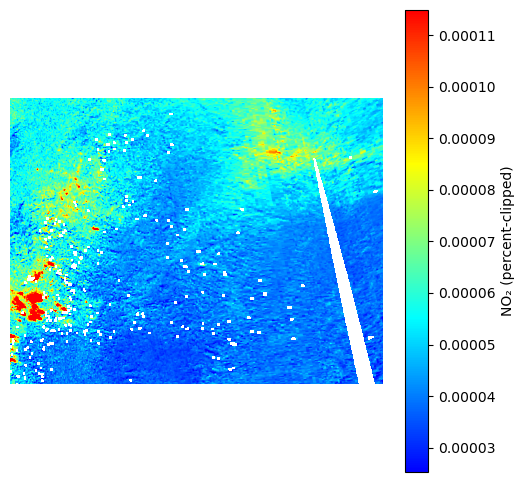

In [9]:
import matplotlib.pyplot as plt

# plot original image
src, band, profile, nodata_value = read_tiff(demo_path / 'Ethiopia_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5)
plt.show()

From the figure above, there are missing values in the plot, representing by the white raster. 

Let us see what happens after the filling process.

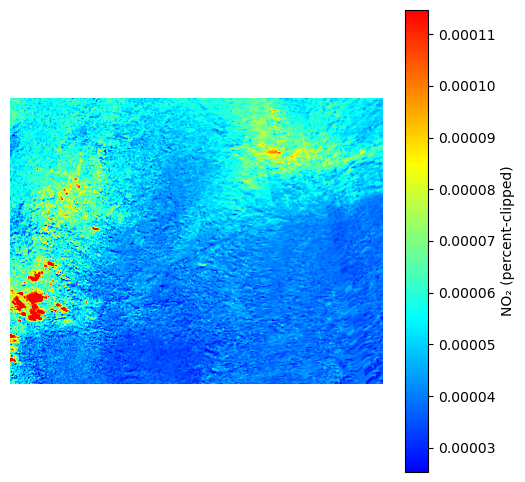

In [ ]:
# filled image
src, band_filled, profile, nodata_value = read_tiff(demo_path / 'Ethiopia_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5)
plt.show()

It is clear thar the small missing parts in the original figure are filled perfectly.

#### Iraq

After processed the following cell, comment it.

In [ ]:
from missingvalue import fill_missing_data

iraq_tiff_path = data_root / 'Iraq-no2'
fill_missing_data('Iraq', data_tiff_path=iraq_tiff_path, output_path=data_root)

**Visualization**

Use *Iraq_NO2_2023-01-01.tif* file as an exmaple to show the results of filling missing value.

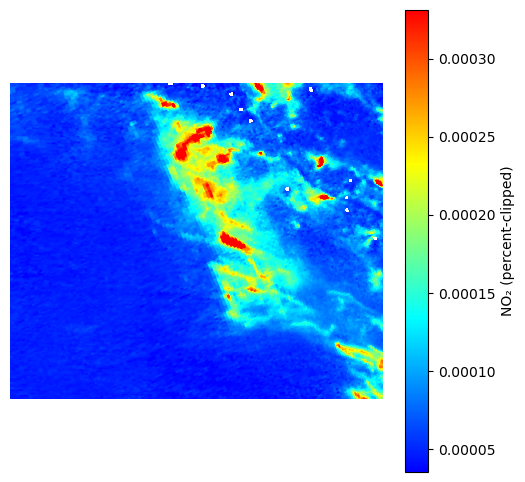

In [ ]:
import matplotlib.pyplot as plt

# plot original image
src, band, profile, nodata_value = read_tiff(demo_path / 'Iraq_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5)
plt.show()

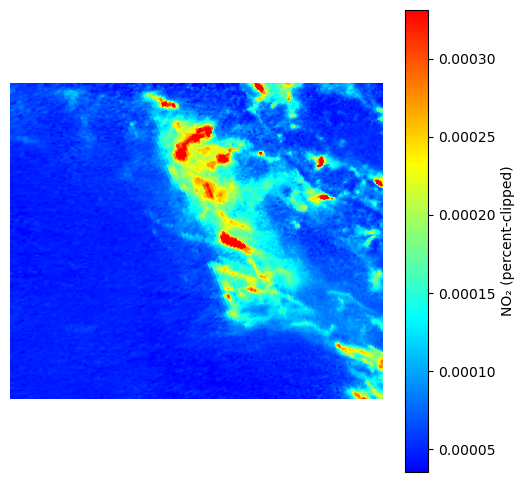

In [ ]:
# filled image
src, band_filled, profile, nodata_value = read_tiff(demo_path / 'Iraq_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5)
plt.show()

Similarly, the small missing value areas in upper right is filled perfectly. Thus, the iterative filling method can significantly enhance the data quality.

### 1.2 Aggregate Based on Mesh Grid

In [ ]:
from aggregation import*

addis_meshes_path = data_root / 'addis-mesh-data'
baghdad_meshes_path = data_root / 'baghdad-mesh-data'

mesh_addis = data_root / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = data_root / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]

#### Ethiopia - Addis Ababa

In [ ]:
# Aggregate Ethiopia - Addis Ababa
eth_no2_filled_path = data_root / 'Ethiopia-no2-filled'
aggregate_data(
    data_tiff_path=eth_no2_filled_path, 
    mesh_path=addis_meshes_path, 
    layer_name=lyr_addis_name
    )

**Visualization**

Show aggregated result in 2023-01-01 in Addis Ababa.

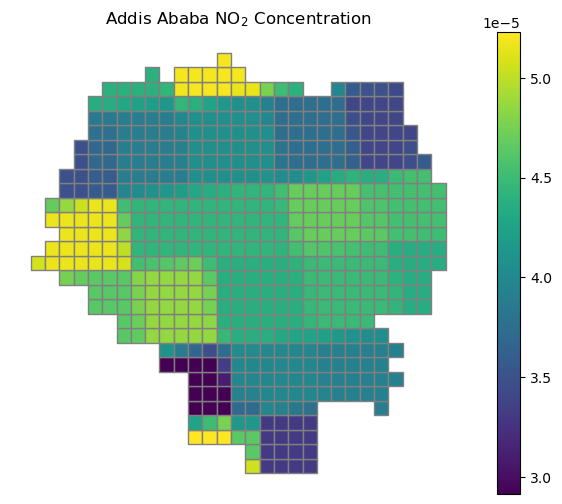

In [21]:
demo_mesh = gpd.read_file(demo_path / 'addis-ababa-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Addis Ababa NO$_2$ Concentration")
plt.show()

#### Iraq - Baghdad

In [ ]:
# Aggregate Iraq - Baghdad
iraq_no2_filled_path = data_root / 'Iraq-no2-filled'
aggregate_data(
    data_tiff_path=iraq_no2_filled_path, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name
    )

**Visualization**

Show aggregated result in 2023-01-01 in Baghdad.

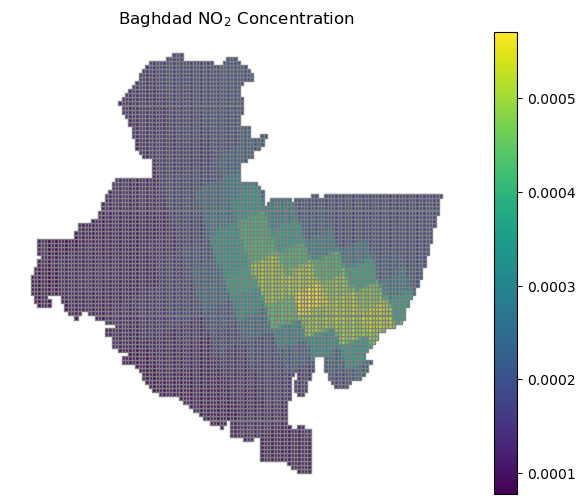

In [11]:
demo_mesh = gpd.read_file(demo_path / 'baghdad-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Baghdad NO$_2$ Concentration")
plt.show()

## 2 Data Visualisation

This chapter is used to generate a dynatmic figure, to show how the NO2 distribution changes over time.

Note:

- In the coloration system, percentile clipping and contrast streching method is uesd to imporve the visual effects of the image.

- In this chapter, the dynamic distribution of NO2 is generated, in format of GIF. 

### 2.1 Dynamic NO2 Distribution - Country Level

#### Ethiopia

Scanning percentiles: 100%|██████████| 711/711 [01:03<00:00, 11.29it/s]


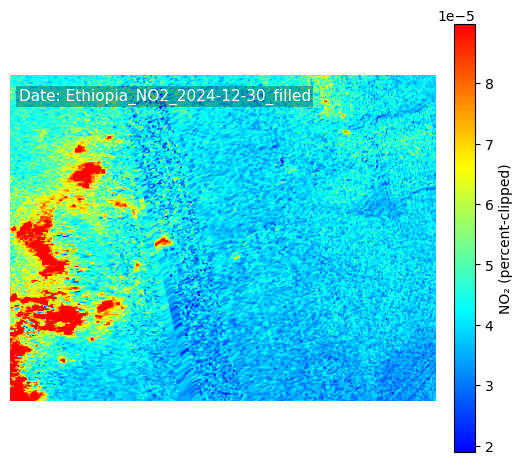

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\ethiopia-no2-animation.gif


In [26]:
no2_eth_tif_dir = data_root / 'Ethiopia-no2-filled'  
tiff_2_gif(no2_eth_tif_dir, output_path=data_root, output_name="ethiopia-no2-animation", fps = 8)

#### Iraq

Scanning percentiles: 100%|██████████| 720/720 [00:32<00:00, 21.93it/s]


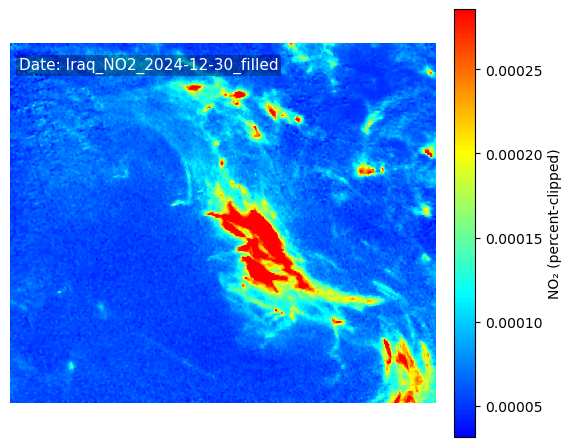

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\iraq-no2-animation.gif


In [27]:
no2_iraq_tif_dir= data_root / 'Iraq-no2-filled'  
tiff_2_gif(no2_iraq_tif_dir, output_path=data_root, output_name="iraq-no2-animation", fps = 8)

### 2.2 Dynamic NO2 Mesh - City Level

**Addis Ababa**

Scanning percentiles:   0%|          | 0/731 [00:00<?, ?it/s]

Scanning percentiles: 100%|██████████| 731/731 [00:05<00:00, 142.14it/s]


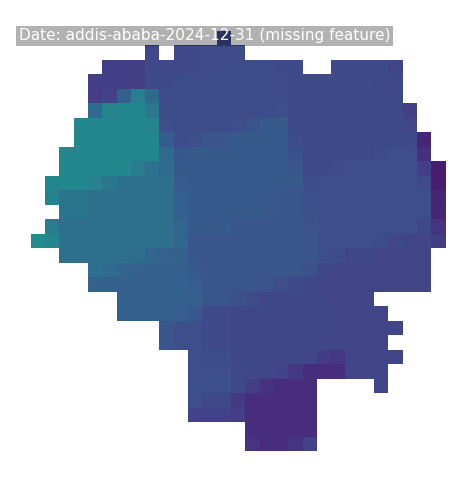

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\addis-ababa-no2-animation.gif


In [2]:
addis_gpkg_path = data_root / 'addis-mesh-data'

mesh_2_gif(
    gpkg_path=addis_gpkg_path, 
    output_path=data_root,
    output_name= "addis-ababa-no2-animation", 
    feature='no2_mean',
   )
plt.show()

**Baghdad**

Scanning percentiles: 100%|██████████| 731/731 [00:22<00:00, 31.93it/s]


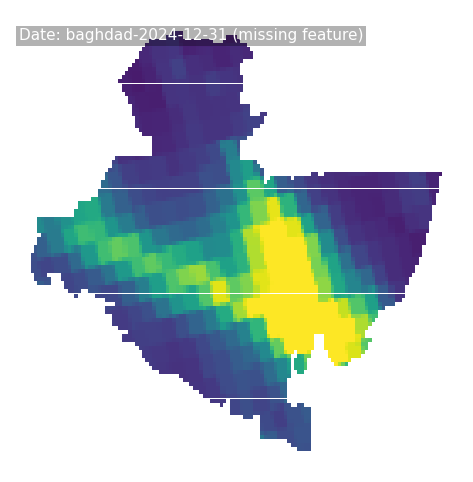

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\baghdad-no2-animation.gif


In [3]:
baghdad_gpkg_path = data_root / 'baghdad-mesh-data'

mesh_2_gif(
    gpkg_path=baghdad_gpkg_path, 
    output_path=data_root,
    output_name= "baghdad-no2-animation", 
    feature='no2_mean',
   )
plt.show()

## 3 Exploratory Data Analysis


#### Addis Ababa
In temporal analysis, we grouped days considering working schema from Ethiopia, including **Workdays**, **Weekends**.

- Type 1 - Workdays: Mon-Fri
- Type 2 - Weekends: Fri-Sun

#### Baghdad

In temporal analysis, we grouped days considering working schema from Iraq **Mon-Tue-Wed**, **Fri-Sat**, **Thu-Sun**.

- Type 1 - Working days: Mon-Tue-Wed
- Type 2 - Extended working days: Thu-Sun     
- Type 3 - Weekends: Fri-Sat

Day type is encoded using *int* type.

### 3.1 Temporal Analysis

In [12]:
import os
import glob
from datetime import datetime
import geopandas as gpd
import pandas as pd

# -----------------------------------------------------------
# Parameters
# -----------------------------------------------------------
addis_meshes_path = data_root / "addis-mesh-data"                        # folder with *.gpkg
date_table_path = data_root / "helper-files" / "workday_type_2023_2024.csv"
feature_col = "no2_mean"                           # numeric field to average
grid_id_col = "geom_id"                       # unique grid identifier
output_path = data_root / "exploratory-data-analysis" / "mean_mesh_workdays_weekends.gpkg" # output file
# -----------------------------------------------------------

# 1. Load the date table and build a lookup dict
date_df = pd.read_csv(date_table_path, parse_dates=["Date"])
date_df["Date_str"] = date_df["Date"].dt.strftime("%Y-%m-%d")
date_class_map = dict(zip(date_df["Date_str"], date_df["Ethiopia_Workday_Type"]))

# 2. Scan all GPKG files
file_paths = sorted(glob.glob(os.path.join(addis_meshes_path, "*.gpkg")))

# 3. Containers for Workdays / Weekends
group_frames = {"Workdays": [], "Weekends": []}

for fp in file_paths:
    # Extract YYYY-MM-DD from filename
    date_str = os.path.basename(fp).split("addis-ababa-")[-1].split(".gpkg")[0]

    # Find its class via the lookup table
    group_key = date_class_map.get(date_str)
    if group_key not in group_frames:
        raise KeyError(f"Date {date_str} not found in date table.")

    # Read the GeoPackage (vector grid)
    gdf = gpd.read_file(fp)

    # Check if feature_col exists, if not, skip this file
    if feature_col not in gdf.columns:
        print(f"Warning: '{feature_col}' not found in {fp}, skipping this file.")
        continue

    # Select needed columns
    gdf = gdf[[grid_id_col, feature_col, "geometry"]]

    # Push into the correct list
    group_frames[group_key].append(gdf)


# 4. Compute mean mesh for each class
mean_frames = {}
for group_key, frames in group_frames.items():
    if not frames:
        raise ValueError(f"No files found for {group_key}!")

    # Stack all days -> one big DataFrame
    stacked = pd.concat(frames, ignore_index=True)

    # Mean by grid id
    mean_df = (
        stacked.groupby(grid_id_col, as_index=False)
               .agg({feature_col: "mean"})
               .rename(columns={feature_col: f"{group_key}_mean"})
    )

    # Add geometry from the first day (all grids share geometry)
    geom_ref = frames[0][[grid_id_col, "geometry"]]
    mean_gdf = gpd.GeoDataFrame(
        mean_df.merge(geom_ref, on=grid_id_col, how="left"),
        geometry="geometry",
        crs=frames[0].crs
    )

    mean_frames[group_key] = mean_gdf

# 5. Merge Workdays & Weekends side-by-side
final_gdf = (
    mean_frames["Workdays"]
    .merge(mean_frames["Weekends"].drop(columns="geometry"),
           on=grid_id_col, how="left")
)

# 6. Save the result
final_gdf.to_file(output_path, layer="mean_mesh", driver="GPKG")
print(f"Saved mean meshes to {output_path}")



Saved mean meshes to D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\exploratory-data-analysis\mean_mesh_workdays_weekends.gpkg


In [ ]:
import os
import glob
from datetime import datetime
import geopandas as gpd
import pandas as pd

# -----------------------------------------------------------
# 0. Parameters you may want to adjust
# -----------------------------------------------------------
DATA_DIR = r"./gpkg_files"                  # folder containing *.gpkg
FILENAME_TEMPLATE = "addis-ababa-%Y-%m-%d"  # pattern before ".gpkg"
VALUE_COLUMN = "value"                      # column holding the numeric value
GRID_ID_COLUMN = "cell_id"                  # unique id for each mesh cell
OUTPUT_FILE = "workdays_weekends_mean.gpkg" # result file
# -----------------------------------------------------------

def classify_date(date_obj):
    """Return 'Workdays' for Mon–Fri else 'Weekends'."""
    return "Workdays" if date_obj.weekday() < 5 else "Weekends"

# 1. Scan all GPKG files
file_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.gpkg")))

# Containers: will accumulate one GeoDataFrame per class
group_frames = {"Workdays": [], "Weekends": []}

for fp in file_paths:
    # 2. Parse date from filename
    basename = os.path.splitext(os.path.basename(fp))[0]             # addis-ababa-2023-01-01
    date_str = basename.split("addis-ababa-")[-1]                    # 2023-01-01
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    
    # 3. Decide Workday / Weekend
    group_key = classify_date(date_obj)
    
    # 4. Read the GeoPackage
    gdf = gpd.read_file(fp)
    
    # 5. Keep only grid id, geometry, and the value column
    gdf = gdf[[GRID_ID_COLUMN, VALUE_COLUMN, "geometry"]]
    
    # 6. Store into the corresponding list
    group_frames[group_key].append(gdf)

# 7. Compute the mean grid for each group
mean_results = []

for group_key, frames in group_frames.items():
    if not frames:
        raise ValueError(f"No files found for group {group_key}")
    
    # Concatenate vertically: rows = all days stacked
    stacked = pd.concat(frames, ignore_index=True)
    
    # Group by grid ID, compute mean of VALUE_COLUMN
    mean_gdf = (
        stacked
        .groupby(GRID_ID_COLUMN, as_index=False)
        .agg({VALUE_COLUMN: "mean"})
    )
    
    # Merge back geometry (take it from the first day)
    geom_ref = frames[0][[GRID_ID_COLUMN, "geometry"]]
    mean_gdf = mean_gdf.merge(geom_ref, on=GRID_ID_COLUMN, how="left")
    
    # Save column name indicating the class
    mean_gdf = gpd.GeoDataFrame(mean_gdf, geometry="geometry", crs=frames[0].crs)
    mean_gdf.rename(columns={VALUE_COLUMN: f"{group_key}_mean"}, inplace=True)
    mean_results.append(mean_gdf)

# 8. Combine Workdays & Weekends into one GeoDataFrame (side-by-side)
combined = mean_results[0][[GRID_ID_COLUMN, "geometry"]].copy()
for gdf in mean_results:
    combined = combined.merge(
        gdf.drop(columns="geometry"), on=GRID_ID_COLUMN, how="left"
    )

# 9. Save to a new GeoPackage (or any other format you like)
combined.to_file(OUTPUT_FILE, layer="mean_mesh", driver="GPKG")
print(f"Saved mean meshes to {OUTPUT_FILE}")


In [7]:
# -- after reading date_df ------------------------------------------------
print("Earliest date in table:", date_df['Date'].min())
print("Latest   date in table:", date_df['Date'].max())
print("Sample keys in map:", list(date_class_map)[:5])

# -- just before the KeyError check --------------------------------------
print("File:", fp)
print("Parsed date_str:", date_str)


Earliest date in table: 2023-01-01 00:00:00
Latest   date in table: 2024-12-31 00:00:00
Sample keys in map: ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']
File: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\addis-mesh-data\addis-ababa-2023-01-01.gpkg
Parsed date_str: 2023-01-01


In [14]:
eth_day = gpd.read_file(output_path)
eth_day

,geom_id,Workdays_mean,Weekends_mean,geometry
0,0,0.000049,0.000049,"POLYGON ((38.78925 8.83942, 38.78925 8.84841, ..."
1,1,0.000049,0.000049,"POLYGON ((38.79824 8.83942, 38.79824 8.84841, ..."
2,2,0.000049,0.000049,"POLYGON ((38.80722 8.83942, 38.80722 8.84841, ..."
3,3,0.000049,0.000049,"POLYGON ((38.8162 8.83942, 38.8162 8.84841, 38..."
4,4,0.000049,0.000049,"POLYGON ((38.82519 8.83942, 38.82519 8.84841, ..."
...,...,...,...,...
541,541,0.000058,0.000054,"POLYGON ((38.75332 9.08197, 38.75332 9.09095, ..."
542,542,0.000057,0.000053,"POLYGON ((38.7623 9.08197, 38.7623 9.09095, 38..."
543,543,0.000056,0.000052,"POLYGON ((38.77129 9.08197, 38.77129 9.09095, ..."
544,544,0.000056,0.000051,"POLYGON ((38.78027 9.08197, 38.78027 9.09095, ..."


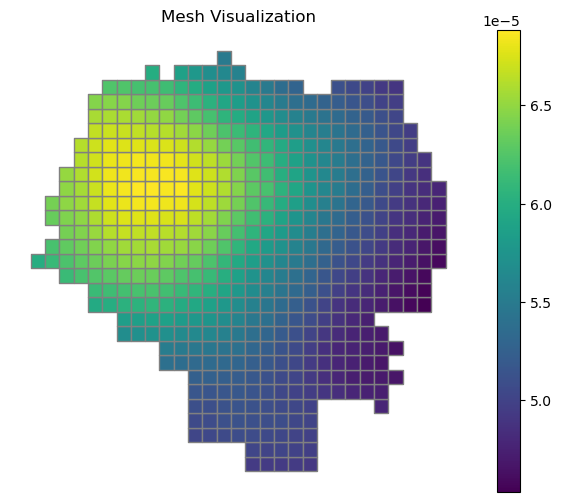

<AxesSubplot:title={'center':'Mesh Visualization'}>

In [15]:
plot_mesh(eth_day, "Workdays_mean")

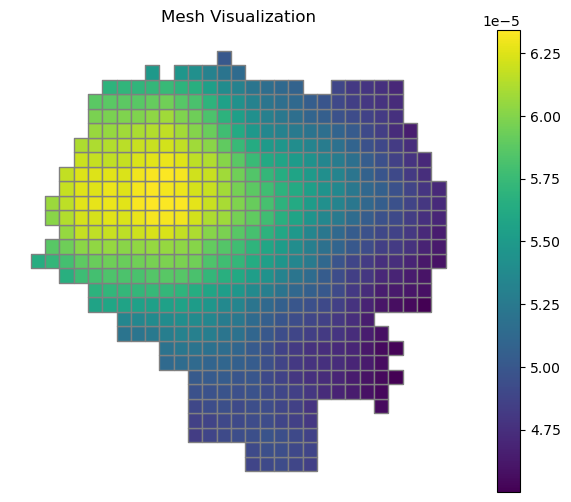

<AxesSubplot:title={'center':'Mesh Visualization'}>

In [16]:
plot_mesh(eth_day, "Weekends_mean")

In [ ]:
gpd.read_file(data_root / "addis-mesh-data" / "addis-ababa-2023-01-01.gpkg")

In [ ]:
gpd.read_file(data_root / "addis-mesh-data" / "addis-ababa-2023-01-01.gpkg")

### 3.2 Spacial Analysis

###